In [1]:
import pandas as pd
import numpy as np
from time import time

In [2]:
okc = pd.read_csv('../Assets/A/one_long_essay.csv', index_col='Unnamed: 0')

In [3]:
def denull(essay):
    if type(essay) == float:
        return ''
    else: return essay
    
okc.essays = okc.essays.apply(denull)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
t0 = time()
vec = TfidfVectorizer(encoding='utf-8', stop_words='english', max_features=2000)
tf = vec.fit_transform(okc.essays)
print "vectorized essays in %g seconds" %(time()-t0)

vectorized essays in 16.1264 seconds


In [6]:
tf = pd.DataFrame(tf.toarray(), columns=vec.get_feature_names())

In [7]:
# Save any features we might want to filter by to tf dataframe
features = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 
           'height', 'income', 'job', 'offspring', 'orientation', 'pets', 'religion', 
            'sex', 'sign', 'smokes', 'speaks']

In [8]:
for feature in features:
    tf['X%s' %feature] = okc[feature]

In [9]:
# Handle some common conjunctions which get separated from words
# leading to features like 'don' and 'll

tf = tf.rename(columns = {'don':"don't", 'll':"i'll", 've':"i've"})

In [10]:
# Save average tfidf score for each word overall to compare with the averages for different groups
mean_words = tf.iloc[:,:2000].mean(axis=0)

### Find top words by tf-idf score

In [11]:
mean_words.sort_values(inplace=True, ascending=False)

In [12]:
# add something to this for hue?
mean_words[:60].to_csv('../Assets/Scaled/top_words.csv')

In [13]:
# Save a single string with top words for each category.  This list will be exported to a .txt file at end of script
all_lists = ''

### Compare word frequency for men vs. women

In [14]:
# Compute mean value of each of first 2000 columns for men
t0 = time()
mdf = tf[tf.Xsex=='m']
df = pd.DataFrame(mdf.iloc[:,:2000].mean(axis=0), columns = ['m'])
print time()-t0

0.74408698082


In [15]:
# Compute mean value of each of first 2000 columns for women
t0 = time()
fdf = tf[tf.Xsex == 'f']
df['f'] = fdf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.509496927261


In [16]:
df['avg'] = mean_words
df['diff'] = (df.m-df.avg)/df.avg

In [17]:
df.sort_values('diff', inplace=True)

In [18]:
# Top words for women are bottom words for men
# All users must report one of these two genders

# Save top 200 words for women and men for report
women_list = ''
for word in df.index[:200]:
    women_list = women_list + word + ', '
    
men_list = ''
# Write men_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    men_list = men_list + df.index[i] + ', '
    
all_lists = 'Women \n \n' + women_list + '\n\n Men \n\n' + men_list

In [19]:
# Save top 30 from each cat
# women
df.sort_values('diff', inplace=True)
f = pd.DataFrame(df.head(30)['f'])
f.columns = ['tfidf']
f['label'] = 'female'

# men
df.sort_values('diff', inplace=True, ascending=False)
m = pd.DataFrame(df.head(30)['m'])
m.columns = ['tfidf']
m['label'] = 'male'


df_sex = pd.concat([m, f], axis=0)

df_sex.to_csv('../Assets/Scaled/df_sex.csv')

### Compare word frequency for social drinkers vs. heavy drinkers vs. non drinkers

In [20]:
# Compare word frequency for social drinkers vs. heavy drinkers vs. non drinkers

# Compute mean value of each of first 2000 columns for social drinks
t0 = time()
ddf = tf[tf.Xdrinks=='socially']
df = pd.DataFrame(ddf.iloc[:,:2000].mean(axis=0), columns = ['social'])
print time()-t0

1.06595015526


In [21]:
# Compute mean value of each of first 2000 columns for non-drinkers
t0 = time()
ddf = tf.query("Xdrinks == 'rarely'|Xdrinks == 'not at all'")
df['non-drinker'] = ddf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.324437856674


In [22]:
# Compute mean value of each of first 2000 columns for heavy drinkers
t0 = time()
ddf = tf.query("Xdrinks == 'often'|Xdrinks == 'very often'|Xdrinks == 'desperately'")
df['heavy'] = ddf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.191416978836


In [23]:
df['avg'] = mean_words
# Compute differences between social drinkers' values and other categories
df['nd_diff'] = (df['non-drinker'] - df['avg'])/df.avg
df['h_diff'] = (df['heavy'] - df['avg'])/df.avg
df['s_diff'] = (df['social'] - df['avg'])/df.avg

In [24]:
# Save top 200 words for heavy, social, and non-drinkers for report
# heavy drinkers:
df.sort_values('h_diff', ascending=False, inplace=True)

heavy_list = ''
for word in df.index[:200]:
    heavy_list = heavy_list + word + ', '

# social drinkers:
df.sort_values('s_diff', ascending=False, inplace=True)

social_list = ''
for word in df.index[:200]:
    social_list = social_list + word + ', '
    
# non-drinkers:
df.sort_values('nd_diff', ascending=False, inplace=True)

non_list = ''
for word in df.index[:200]:
    non_list = non_list + word + ', '
    
all_lists = all_lists +  '\n\nDrink heavily \n \n' +  heavy_list + '\n\nDrink socially \n\n' + social_list + '\n\nDo not drink regularly \n\n'+ non_list

In [25]:
# Save top 18 from each cat
# non-drinkers first
df.sort_values('nd_diff', inplace=True, ascending=False)
nd = pd.DataFrame(df.head(18)['non-drinker'])
nd.columns = ['tfidf']
nd['label'] = 'non-drinker'

# social drinkers
df.sort_values('s_diff', inplace=True, ascending=False)
sd = pd.DataFrame(df.head(18)['social'])
sd.columns = ['tfidf']
sd['label'] = 'social'

# heavy drinkers
df.sort_values('h_diff', inplace=True, ascending=False)
hd = pd.DataFrame(df.head(18)['heavy'])
hd.columns = ['tfidf']
hd['label'] = 'heavy'

df_drinks = pd.concat([nd, sd, hd], axis=0)

df_drinks.to_csv('../Assets/Scaled/df_drinks.csv')

### Explore word choice by age

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show>

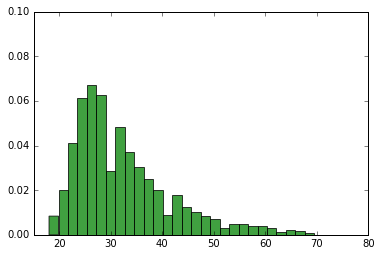

In [27]:
plt.hist(okc.age, 50, normed=1, facecolor='green', alpha=0.75)
plt.axis([15, 80, 0, .1])
plt.show

In [28]:
# Compare under 30 to over 30

def age_encoder(age):
    if age ==0:
        return np.nan
    elif age < 30:
        return 0
    else:
        return 1
    
tf.Xage = tf.Xage.apply(age_encoder)

In [29]:
# Compare word frequency for under 30 vs. over 30

# Compute mean value of each of first 2000 columns for over 30
t0 = time()
odf = tf[tf.Xage==1]
df = pd.DataFrame(odf.iloc[:,:2000].mean(axis=0), columns = ['>30'])
print time()-t0

# Compute mean value of each of first 2000 columns for under 30
ydf = tf[tf.Xage == 0]
df['<30'] = ydf.iloc[:,:2000].mean(axis=0)
print time()-t0


0.786000967026
1.58615088463


In [30]:
df['avg'] = mean_words
df['older_diff'] = (df['>30']-df.avg)/df.avg
df['younger_diff'] = (df['<30']-df.avg)/df.avg

In [31]:
# Save top 200 words for people under and over 30
# older people:
df.sort_values('older_diff', ascending=False, inplace=True)

older_list = ''
for word in df.index[:200]:
    older_list = older_list + word + ', '

# save top 30 words with tfidf scores to df
o = pd.DataFrame(df.head(30)['>30'])
o.columns = ['tfidf']
o['label'] = '>30'

# younger people

df.sort_values('younger_diff', ascending=False, inplace=True)

younger_list = ''
for word in df.index[:200]:
    younger_list = younger_list + word + ', '

y = pd.DataFrame(df.head(30)['<30'])
y.columns = ['tfidf']
y['label'] = '<30'    

    
all_lists = all_lists + '\n\nOver 30 \n \n' + older_list + '\n\nUnder 30 \n\n' + younger_list


df_age = pd.concat([y, o], axis=0)

df_age.to_csv('../Assets/Scaled/df_age.csv')

### Compare drug users and non-users
exclude those who don't report

In [32]:
def drug_encoder(drugs):
    if drugs == 'never':
        return 0
    elif drugs == 'sometimes' or drugs == 'often':
        return 1
    else:
        return np.nan
    
tf.Xdrugs = tf.Xdrugs.apply(drug_encoder)

In [33]:
# Compute mean value of each of first 2000 columns for drug users
t0 = time()
udf = tf[tf.Xdrugs==1]
df = pd.DataFrame(udf.iloc[:,:2000].mean(axis=0), columns = ['users'])
print time()-t0

# Compute mean value of each of first 2000 columns for non-users
ndf = tf[tf.Xdrugs == 0]
df['non-users'] = ndf.iloc[:,:2000].mean(axis=0)
print time()-t0

1.85290789604
2.576597929


In [34]:
df['avg'] = mean_words
df['user_diff'] = (df['users']-df.avg)/df['avg']
df['non-user_diff'] = (df['non-users']-df.avg)/df['avg']

In [35]:
df.sort_values('user_diff', ascending=False, inplace=True)

In [36]:
# Save top 200 words for users and non-users
# users:
df.sort_values('user_diff', ascending=False, inplace=True)

user_list = ''
for word in df.index[:200]:
    user_list = user_list + word + ', '

    
u = pd.DataFrame(df.head(30)['users'])
u.columns = ['tfidf']
u['label'] = 'users'

# non-users
df.sort_values('non-user_diff', ascending=False, inplace=True)
non_user_list = ''
# Write older_list in reverse order so most popular words are on top
for word in df.index[:200]:
    non_user_list = non_user_list+ word +', '
    
n = pd.DataFrame(df.head(30)['non-users'])
n.columns = ['tfidf']
n['label'] = 'non-users'
    
all_lists = all_lists + '\n\nUse drugs \n \n' + user_list + '\n\nDo not use drugs \n\n' + non_user_list


df_drugs = pd.concat([u, n], axis=0)

df_drugs.to_csv('../Assets/Scaled/df_drugs.csv')

### Explore Income

<function matplotlib.pyplot.show>

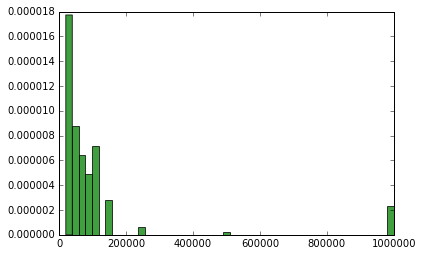

In [37]:
plt.hist(tf.Xincome[tf.Xincome != -1], 50, normed=1, facecolor='green', alpha=0.75)
plt.show

In [38]:
# Divide income income into <50k, 50-100k, >100k

def income_encoder(income):
    if income == -1:
        return -1
    elif income <= 50000:
        return 0
    elif income <= 100000:
        return 1
    else:
        return 2
    
tf.Xincome = tf.Xincome.apply(income_encoder)

In [39]:
# Compare word frequency for different income levels

# Compute mean value of each of first 2000 columns for lower income
t0 = time()
pdf = tf[tf.Xincome==0]
df = pd.DataFrame(pdf.iloc[:,:2000].mean(axis=0), columns = ['<50k'])
print time()-t0

# Compute mean value of each of first 2000 columns for middle income
t0 = time()
mdf = tf[tf.Xincome==1]
df['50-100k'] = mdf.iloc[:,:2000].mean(axis=0)
print time()-t0

# Compute mean value of each of first 2000 columns for highest income
t0 = time()
rdf = tf[tf.Xincome==2]
df['>100k'] = rdf.iloc[:,:2000].mean(axis=0)
print time()-t0


# Compute differences between each income category and overall average
df['avg'] = mean_words
df['r_diff'] = (df['>100k']-df.avg)/df['avg']
df['p_diff'] = (df['<50k']-df.avg) /df['avg']
df['m_diff'] = (df['50-100k']-df.avg)/df['avg']

0.149991035461
0.111409187317
0.0517578125


In [40]:
# Save lists for each income bracket

df.sort_values('r_diff', ascending=False, inplace=True)

upper_list = ''
for word in df.index[:200]:
    upper_list = upper_list + word + ', '
    
df2 = pd.DataFrame(df.head(18)['>100k'])
df2.columns = ['tfidf']
df2['label'] = '> 100k'
    
df.sort_values('m_diff', ascending=False, inplace=True)

mid_list = ''
for word in df.index[:200]:
    mid_list = mid_list + word + ', '

df3 = pd.DataFrame(df.head(18)['50-100k'])
df3.columns = ['tfidf']
df3['label'] = '50 - 100k'

df.sort_values('p_diff', ascending=False, inplace=True)    
lower_list = ''
for word in df.index[:200]:
    lower_list = lower_list + word + ', '
    
df4 = pd.DataFrame(df.head(18)['<50k'])
df4.columns = ['tfidf']
df4['label'] = '< 50k'

df_income = pd.concat([df2, df3, df4], axis=0)
df_income.to_csv('../Assets/Scaled/df_income.csv')

all_lists = all_lists + '\n\nMake over 100k annually \n \n' + upper_list + '\n\nMake 50-100k annually\n\n' + mid_list+ '\n\nMake less than 50k annually\n\n'+lower_list

### Compare dog and cat people

In [41]:
# calculate dummy columns for likes dogs and likes cats
# will be some overlap since not mutually exclusive

def mask_dogs(pets):
    # catches 'has dogs' or 'likes dogs'
    try:
        if pets.find('dogs') > -1:
            if pets.find('dislikes dogs') == -1:
                return 1
        else:
            return 0
    except:
        return 0
    
def mask_cats(pets):
    try:
        if pets.find('cats') > -1:
            if pets.find('dislikes cats') == -1:
                return 1
        else:
            return 0
    except:
        return 0

tf['Xdogs'] = tf.Xpets.apply(mask_dogs)
tf['Xcats'] = tf.Xpets.apply(mask_cats)

In [42]:
# find mean scores for dog people

t0 = time()
ddf = tf[tf.Xdogs==1]
df = pd.DataFrame(ddf.iloc[:,:2000].mean(axis=0), columns = ['dogs'])
print time()-t0

# find mean scores for cat people
cdf = tf[tf.Xcats == 1]
df['cats'] = cdf.iloc[:,:2000].mean(axis=0)
print time()-t0

2.69917392731
3.21575403214


In [43]:
df['avg'] = mean_words
df['dog_diff'] = (df['dogs']-df.avg)/df.avg
df['cat_diff'] = (df['cats']-df.avg)/df.avg

In [44]:
# Save top 200 words for cats and dogs for report
df.sort_values('cat_diff', inplace=True, ascending=False)
cat_list = ''
for word in df.index[:200]:
    cat_list = cat_list + word + ', '
    
n = pd.DataFrame(df.head(30)['cats'])
n.columns = ['tfidf']
n['label'] = 'cats'

df.sort_values('dog_diff', inplace=True, ascending=False)
dog_list = ''
# Write dog_list in reverse order so most popular words are on top
for word in df.index[:200]:
    dog_list = dog_list + word + ', '
    
m = pd.DataFrame(df.head(30)['dogs'])
m.columns = ['tfidf']
m['label'] = 'dogs'

all_lists = all_lists + '\n\nLike cats\n \n' + cat_list + '\n\nLike dogs \n\n' + dog_list

df_pets = pd.concat([m, n], axis=0)

df_pets.to_csv('../Assets/Scaled/df_pets.csv')

### Explore word choice by education

college grad? 1 or 0.

In [45]:
def ed_encoder(ed):
    # a person is a college grad if they either "graduated from college/university"
    # or mention law school, med, school, masters program or ph. d program (all instances of the word program are graduate )
    try:
        if ed == 'graduated from college/university' or ed.find('law') >= 0 or ed.find('med') >= 0 or ed.find('program') >= 0:
            return 1
        # space camp answers are facetious and must be excluded
        # BTW I am in space camp right now
        elif ed.find('space camp') >= 0:
            return np.nan
        else: return 0
    except:
        return np.nan

tf.Xeducation = tf.Xeducation.apply(ed_encoder)

In [46]:
# Compare word frequency for college educated vs. not college

# Compute mean value of each of first 2000 columns for college grads
t0 = time()
df2 = tf[tf.Xeducation==1]
df = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0), columns = ['grad'])
print time()-t0

# Compute mean value of each of first 2000 columns for under 30
df2 = tf[tf.Xage == 0]
df['non-grad'] = df2.iloc[:,:2000].mean(axis=0)
print time()-t0

df['avg'] = mean_words

df['grad_diff'] = (df['grad']-df.avg)/df.avg
df['ng_diff'] = (df['non-grad']-df.avg)/df.avg

# non grads
df.sort_values('ng_diff', inplace=True, ascending=False)
non_grad_list = ''
for word in df.index[:200]:
    non_grad_list = non_grad_list + word + ', '
    
# save df
n = pd.DataFrame(df.head(30)['non-grad'])
n.columns = ['tfidf']
n['label'] = 'non-grads'

# grads
grad_list = ''
df.sort_values('grad_diff', inplace=True, ascending=False)
for word in df.index[:200]:
    grad_list = grad_list + word + ', '
    
g = pd.DataFrame(df.head(30)['grad'])
g.columns = ['tfidf']
g['label'] = 'grads'
    

# Save top 200's lists to all_lists
all_lists =  all_lists + '\n\nGraduated College\n \n' + grad_list + '\n\nDid Not Graduate College\n\n' + non_grad_list


df_ed = pd.concat([n, g], axis=0)

df_ed.to_csv('../Assets/Scaled/df_ed.csv')



2.36321687698
2.94113397598


In [47]:
print all_lists

Women 
 
heels, baking, jane, adore, yummy, adele, bones, holiday, flowers, queer, chick, florence, girl, curly, yoga, grey, chocolate, shopping, amelie, daughter, twilight, sister, pets, pride, hugs, organizing, markets, laughter, animals, recipes, hunger, musicals, brunch, lovely, integrity, dancing, obsessed, gender, laughing, compassionate, sunshine, glee, mumford, glass, cheese, teacher, minds, fashion, garden, wine, students, gardening, loved, volunteering, connecting, independent, sedaris, children, mom, parking, grounded, generous, legs, horses, notebook, quirky, singing, disney, cats, castle, education, scary, museums, hair, passport, cookies, compassion, kindness, iver, loving, silly, committed, dramas, sarah, dog, color, guilty, bell, volunteer, excited, raising, warm, scrabble, handle, bluegrass, affectionate, marathon, dogs, delicious, sisters, edward, dance, cleaning, historical, smile, sweet, ethnic, grown, love, wonderful, profit, bon, mary, yorker, dirty, couch, theatr

### Explore word choice by ethnicity

options are: asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, white

In [48]:
# It will be more efficient to encode dummies for each ethnic group than to search each entry
# People who list multiple ethnicities will count for all ethnicities listed

# write encoder for each ethnicity

groups = ['asian', 'middle eastern', 'black', 'native american', 'indian', 'pacific islander', 'hispanic / latin', 'white']

for ethnicity in groups:
    def ethnicity_encoder(eth):
        global ethnicity
        try:
            if eth.find(ethnicity) >= 0:
                return 1
            else: return 0
        except:
            return 0
        
    tf['X%s' %ethnicity] = tf.Xethnicity.apply(ethnicity_encoder)

In [49]:
df=pd.DataFrame(index=tf.columns[:2000])
# Compute mean value of each of first 2000 columns for each ethnic group
for ethnicity in groups:
    t0 = time()
    df2 = tf[tf['X%s' %ethnicity] == 1]
    df[ethnicity] = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0))
    print time()-t0
    
df['avg'] = mean_words

for ethnicity in groups:
    df['%s_diff' %ethnicity] = (df[ethnicity]-df.avg)/df['avg']

0.230666160583
0.0372850894928
0.104553937912
0.0450990200043
0.054356098175
0.0605130195618
0.164566040039
1.29831600189


In [50]:
# List top 100 words for each ethnicity


# Fill string for each ethnicity with top words
for ethnicity in groups:
    df.sort_values('%s_diff' %ethnicity, ascending=False, inplace=True)
    
    eth_list = ''
    for word in df.index[:100]:
        eth_list = eth_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %ethnicity + eth_list
    

In [51]:
print all_lists

Women 
 
heels, baking, jane, adore, yummy, adele, bones, holiday, flowers, queer, chick, florence, girl, curly, yoga, grey, chocolate, shopping, amelie, daughter, twilight, sister, pets, pride, hugs, organizing, markets, laughter, animals, recipes, hunger, musicals, brunch, lovely, integrity, dancing, obsessed, gender, laughing, compassionate, sunshine, glee, mumford, glass, cheese, teacher, minds, fashion, garden, wine, students, gardening, loved, volunteering, connecting, independent, sedaris, children, mom, parking, grounded, generous, legs, horses, notebook, quirky, singing, disney, cats, castle, education, scary, museums, hair, passport, cookies, compassion, kindness, iver, loving, silly, committed, dramas, sarah, dog, color, guilty, bell, volunteer, excited, raising, warm, scrabble, handle, bluegrass, affectionate, marathon, dogs, delicious, sisters, edward, dance, cleaning, historical, smile, sweet, ethnic, grown, love, wonderful, profit, bon, mary, yorker, dirty, couch, theatr

In [52]:
# There are 8 different ethnic groups available
# Tableau does well with about 50 to 60 words for packed bubbles
# Take top 7 words for each ethnicity

# Drop words asian, middle, eastern, indian, and india as they are top ranking words but redundant with categories

df.drop(['asian', 'middle', 'eastern', 'indian', 'india'], axis=0, inplace=True)

In [53]:
# must have at least one row in dataframe in order to use pd.concat
df_ethnicity = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for ethnicity in groups:
    # Save top 7 words for each ethnicity
    df.sort_values('%s_diff' %ethnicity, ascending=False, inplace=True)
    df3 = pd.DataFrame(df.head(7)[ethnicity])
    df3.columns=['tfidf']
    df3['label'] = ethnicity
    
    df_ethnicity = pd.concat([df_ethnicity, df3], axis=0)
    
# drop dummy row from top
df_ethnicity.drop(0, axis=0, inplace=True)

df_ethnicity.to_csv('../Assets/Scaled/df_ethnicity.csv')
    

### Explore jobs

In [54]:

df = pd.DataFrame(index=tf.columns[:2000])
df_jobs = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
job_dic = {}
# Most popular job category is "other"  Exclude that
for job in tf.Xjob.value_counts()[1:11].index:
    # Save a column of dummies for each job category
    def job_encoder(career):
        global job
        try:
            if career.find(job) >= 0:
                return 1
            else: return 0
        except:
            return 0
    
    tf['X%s' %job] = tf.Xjob.apply(job_encoder)

    # Compute mean tfidf scores for job type
    t0 = time()
    df2 = tf[tf['X%s' %job] == 1]
    df[job] = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0))
    print time()-t0
    
# Compute overall mean tfidf scores
df['avg'] = mean_words

    
for job in tf.Xjob.value_counts()[1:11].index: 
    # compute diff between scores for each job and overall mean
    df['%s_diff' %job] = (df[job] - df['avg'])/df.avg
    

    # sort by job
    # save top 100 words asfor each job
    # save top 6 words with tfidf scores and labels to df_jobs
    job_list = ''
    df.sort_values('%s_diff' %job, ascending=False, inplace=True)
    # save top 200 words to reserved string in job_dic
    for word in df.index[:100]:
        job_list = job_list + word + ', '
    
    all_lists = all_lists + '\n\n%s\n\n' %job + job_list
        
    # Save top 6 words to df_jobs
    df.sort_values('%s_diff' %job, ascending=False, inplace=True)
    
    df3 = pd.DataFrame(df.head(6)[job])
    df3.columns=['tfidf']
    df3['label'] = job
    
    df_jobs = pd.concat([df_jobs, df3], axis=0)
    
# drop dummy row from top
df_jobs.drop(0, axis=0, inplace=True)

df_jobs.to_csv('../Assets/Scaled/df_jobs.csv')


0.155715942383
0.126802921295
0.138172864914
0.116590023041
0.132436990738
0.105093955994
0.10789680481
0.0849359035492
0.0842781066895
0.0797090530396


### Look at sexual orientation
Break down by gender as well to account for different cultures in queer community


In [55]:
# Compute mean value of each of first 2000 columns for gay men

df2 = tf[tf.Xsex=='m'][tf.Xorientation=='gay']
df = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0), columns = ['gay men'])


# Compute mean value of each of first 2000 columns for bi men
df2 = tf[tf.Xsex=='m'][tf.Xorientation=='bisexual']
df['bi men'] = df2.iloc[:,:2000].mean(axis=0)


# Compute mean values for straight men
df2 = tf[tf.Xsex=='m'][tf.Xorientation=='straight']
df['straight men'] = df2.iloc[:,:2000].mean(axis=0)


# Compute mean values for gay women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='gay']
df['gay women'] = df2.iloc[:,:2000].mean(axis=0)

# Compute mean values for bi women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='bisexual']
df['bi women'] = df2.iloc[:,:2000].mean(axis=0)

# Compute mean values for straight women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='straight']
df['straight women'] = df2.iloc[:,:2000].mean(axis=0)


df['avg'] = mean_words
df['gay men diff'] = (df['gay men'] - df.avg)/df.avg
df['bi men diff'] = (df['bi men'] - df.avg)/df.avg
df['straight men diff'] = (df['straight men'] - df.avg)/df.avg
df['gay women diff'] = (df['gay women'] - df.avg)/df.avg
df['bi women diff'] = (df['bi women'] - df.avg)/df.avg
df['straight women diff'] = (df['straight women'] - df.avg)/df.avg

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [56]:
# Save word lists
df_orientation = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for group in df.columns[:6]:
    df.sort_values('%s diff' %group, ascending=False, inplace=True)
    group_list = ''
    for word in df.index[:100]:
        group_list = group_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %group + group_list
# Save df for Tableau with top 10 for each category
    df2 = pd.DataFrame(df[group].head(10))
    df2.columns = ['tfidf']
    df2['label'] = group

    
    df_orientation = pd.concat([df_orientation, df2], axis=0)
    
df_orientation.drop(0, axis=0, inplace=True)

df_orientation.to_csv('../Assets/Scaled/df_orientation.csv')

### Explore Religion

In [57]:
# list religions 
religions = []
for religion in tf.Xreligion.value_counts().index:
    rel = religion.split(' ', 1)[0]
    if rel not in religions:
        religions.append(rel)
religions = filter(lambda x: x != 'other', religions)

In [58]:
# Encode dummies for each religion
# rel is individual person's religion string "Christianity and very serious about it"
# religion is each group "Christianity"

tf.Xreligion.replace(np.nan, '', inplace=True)

df = pd.DataFrame()
df_religion = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for religion in religions:
    tf['X%s' %religion] = tf.Xreligion.apply(lambda rel: 1 if rel.split(' ', 1)[0] == religion else 0)

    # Compute mean values for each religion
    df2 = tf[tf['X%s' %religion]==1]
    df[religion] = df2.iloc[:,:2000].mean(axis=0)
    
# Compute mean for each word across religons
df['avg'] = mean_words

for religion in religions:
    df['%s_diff' %religion] = (df[religion] -df['avg'])/df.avg

    # Save top 200 words for each religion as string
    df.sort_values('%s_diff' % religion, inplace=True, ascending=False)
    
    rel_list = ''
    for word in df.index[:100]:
        rel_list = rel_list + word + ', '
        
    all_lists = all_lists + '\n\n%s\n\n' %religion + rel_list
    
    # Save top 7 words for each religon as df for Tableau
    df2 = pd.DataFrame(df[religion].head(7))
    df2.columns = ['tfidf']
    df2['label'] = religion
    
    df_religion = pd.concat([df_religion, df2], axis=0)
    
df_religion.drop(0, axis=0, inplace=True)
df_religion.to_csv('../Assets/Scaled/df_religion.csv')
    

### Religion seriousness

In [59]:
levels = []
for religion in tf.Xreligion.value_counts().index:
    try:
        level = religion.split('and ', 1)[1]
    except: continue
    if level not in levels:
        levels.append(level)

def level_encoder(rel):
    try:
        for level in levels:
            if rel.find(level) >0:
                return level
    except:
        return ''

tf['Xreligiousness'] = tf.Xreligion.apply(level_encoder)

In [60]:
df = pd.DataFrame()
df_religiousness = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
for level in levels:
    # Compute mean values for each level of religiousness
    df2 = tf[tf['Xreligiousness']==level]
    df[level] = df2.iloc[:,:2000].mean(axis=0)
# Compute averages
df['avg'] = df.mean(axis=1)

for level in levels:
    # sort by diff for each category
    df['%s_diff' %level] = df[level] - df['avg']
    df.sort_values('%s_diff' % level, inplace=True, ascending=False)
    # Save top 200 to level_dic
    level_list = ''
    for word in df.index[:200]:
        level_list = level_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %level + level_list
    # Save top 20 to df
    df2 = pd.DataFrame(df[level].head(20))
    df2.columns = ['tfidf']
    df2['label'] = level
    
    df_religiousness = pd.concat([df_religiousness, df2], axis=0)
df_religiousness.drop(0, axis=0, inplace=True)

df_religiousness.to_csv('../Assets/Scaled/df_religiousness.csv')

### Explore Diet

In [61]:
tf.Xdiet.value_counts()

# ignore anything and other
# just look for vegetarian, vegan, kosher, halal

def diet_encoder(diet):
    try:
        if diet.find('vegan') >= 0:
            return 'vegan'
        elif diet.find('vegetarian') >= 0:
            return 'vegetarian'
        elif diet.find('kosher') >= 0:
            return 'kosher'
        elif diet.find('halal') >= 0:
            return 'halal'
        else:
            return ''
    except:
        return ''
    
tf.Xdiet = tf.Xdiet.apply(diet_encoder)

In [62]:
# Exclude '' from diets
diets = tf.Xdiet.value_counts().index[1:]

df = pd.DataFrame()
df_diet = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
for diet in diets:
    # Compute mean values for each level of religiousness
    df2 = tf[tf.Xdiet==diet]
    df[diet] = df2.iloc[:,:2000].mean(axis=0)
# Compute averages
df['avg'] = mean_words

for diet in diets:
    # sort by diff for each category
    df['%s_diff' %diet] = (df[diet] - df['avg'])/df.avg
    df.sort_values('%s_diff' % diet, inplace=True, ascending=False)
    # Save top 100 to level_dic
    diet_list = ''
    for word in df.index[:100]:
        diet_list = diet_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %diet + diet_list
    # Save top 20 to df
    df2 = pd.DataFrame(df[diet].head(15))
    df2.columns = ['tfidf']
    df2['label'] = diet
    
    df_diet = pd.concat([df_diet, df2], axis=0)
df_diet.drop(0, axis=0, inplace=True)

df_diet.to_csv('../Assets/Scaled/df_diet.csv')

In [63]:
# save all_lists to file ../Assets/Tableau/df_all_lists.txt

target = open('../Assets/Scaled/df_all_lists.txt', 'w')

target.write(all_lists)
target.close()

In [64]:
# compare labels w/ encoders vs. labels with dummies for overall correlations
# write script to save dicts to text file

List top 200 lists here:

